## Assignment 4

In this assignment you should compare different criteria used for adaptive design of experiments: random design, optimal latin hypercubes, and posterior variance for predictions. The function you should approximate is an analytical function Beale, see the definition below.

To construct regression models you should use Gaussian process regression from your favorite library (e.g. GPy https://github.com/SheffieldML/GPy)

Note, that computational experiments for this assignment can take a long time, so we encourage you to start the work early.

## Beal function

$$
f(x_1, x_2) = (1.5 - x_1 + x_1 x_2)^2 + (2.25 - x_1 + x_1 x_2^2)^2 + (2.625 - x_1 + x_1 x_2^3)^2,
$$

$(x_1, x_2) \in [-4.5, 4.5]^2.$

### Description of requirements

You should compare the criteria introduced before with respect to decrease of squared error of approximation $E(n)$ as the training sample size $n$ grows.

- To estimation $E(n)$ you should use an independent separate test sample available as we use an analytical function as the target.
— Vary $n$ from $10$ to $100$ points.

For adaptive design of experiments with maximum variance criterion you should use the following approach for the adaptive generation of sample:
 1. Construct a regression model using given sample of size $n$
 2. Find a new points that has the maximum posterior variance in the design space. To speed up selection of this point you can use fine grid of points.
 3. Get $f(x)$ at the new point $x$ and add a pair $(x, f(x))$ to the current sample.
 4. Initial sample of points you should generate using optimal latin hypercube approach.
 5. You should average obtained errors over at least $10$ different runs of initial sample generation.

The final notebook should contain curves of the error curve decline with respect to the sample size for all three criteria.

In [1]:
import numpy as np
import GPy
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def beale(x):
    return np.square(1.5 - x[:, 0] + x[:, 0] * x[:, 1]) + \
        np.square(2.25 - x[:, 0] + x[:, 0] * np.square(x[:, 1])) + \
        np.square(2.625 - x[:, 0] + x[:, 0] * np.power(x[:, 1], 3))

In [3]:
def random_design(n, X_test, y_test):
    X_train = np.random.uniform(-4.5, 4.5, (n, 2))
    y_train = beale(X_train).reshape(-1, 1)
    
    ker = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.) + GPy.kern.White(2, variance=1e7)
    m = GPy.models.GPRegression(X_train, y_train, ker)

    m.optimize()
    
    return np.mean(np.square(m.predict(X_test)[0] - y_test))

def latin_hypercube(n):
    perm_x = np.random.permutation(n)
    perm_y = np.random.permutation(n)
    return (np.hstack([perm_x.reshape(-1, 1), perm_y.reshape(-1, 1)]) + np.random.uniform(size=(n, 2))) / n * 9. - 4.5

def latin_hypercube_design(n, X_test, y_test):
    X_train = latin_hypercube(n)
    y_train = beale(X_train).reshape(-1, 1)
    
#     ker = GPy.kern.Matern52(input_dim=2) 
    ker = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.) + GPy.kern.White(2, variance=1e7)
    m = GPy.models.GPRegression(X_train, y_train, ker)

    m.optimize()
    
    return np.mean(np.square(m.predict(X_test)[0] - y_test))

def mvp_design(n, X_test, y_test):
    X_train = latin_hypercube(n - 1)
    y_train = beale(X_train).reshape(-1, 1)
    
    ker = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.) + GPy.kern.White(2, variance=1e7)
    m = GPy.models.GPRegression(X_train, y_train, ker)
    m.optimize()
    
    x, y = np.meshgrid(np.linspace(-4.5, 4.5, 100), np.linspace(-4.5, 4.5, 100))
    grid = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])
    sigma = m.predict(grid)[1].ravel()
    X_train = np.vstack([X_train, grid[sigma.argmax()]])
    y_train = beale(X_train).reshape(-1, 1)
    
    m = GPy.models.GPRegression(X_train, y_train, ker)
    m.optimize()    
    return np.mean(np.square(m.predict(X_test)[0] - y_test))

In [4]:
X_test = np.random.uniform(-4.5, 4.5, (100, 2))
y_test = beale(X_test).reshape(-1, 1)

In [5]:
from tqdm import tqdm

In [6]:
results = [[], [], []]
funcs = [random_design, latin_hypercube_design, mvp_design]
curr = np.zeros(30)
for i in tqdm(xrange(10, 101)):
    for k in xrange(3):
        for j in xrange(30):
            curr[j] = funcs[k](i, X_test, y_test)
        results[k].append(curr.mean())

  0%|          | 0/91 [00:00<?, ?it/s] /Users/ilia/anaconda/lib/python2.7/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1
 /Users/ilia/anaconda/lib/python2.7/site-packages/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in divide
 /Users/ilia/anaconda/lib/python2.7/site-packages/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square
 /Users/ilia/anaconda/lib/python2.7/site-packages/GPy/kern/src/rbf.py:38: RuntimeWarning:invalid value encountered in multiply
100%|██████████| 91/91 [10:46<00:00,  9.49s/it]


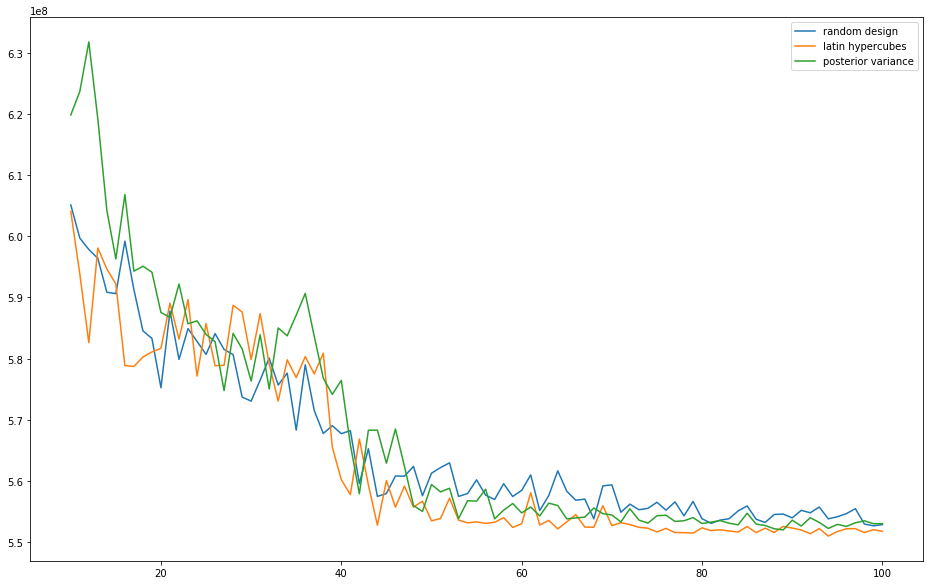

In [9]:
plt.figure(figsize=(16, 10))
plt.plot(range(10, 101), results[0], label='random design')
plt.plot(range(10, 101), results[1], label='latin hypercubes')
plt.plot(range(10, 101), results[2], label='posterior variance')
plt.legend(loc='best')